In [1]:
import os, sys

import pymongo as pm
import base64
import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import socket
import io

from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
%load_ext autoreload
%autoreload 2

### Directory & file hierarchy

In [2]:

proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
[make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir]]

['/Users/kushinm/Documents/Github/things-drawings/results',
 '/Users/kushinm/Documents/Github/things-drawings/results/plots',
 '/Users/kushinm/Documents/Github/things-drawings/results/csv']

### Quick helpers

In [3]:
## transsform base64 png string to image for plotting
def string_to_image(im_string):
    im = io.BytesIO(base64.decodebytes(str.encode(im_string.split(',')[1])))
    im = mpimg.imread(im, format='PNG')
    return im


### function to plot a grid of sketches

def plot_image_grid(concept,dim):

    im_arr = sketch_df[sketch_df.concept==concept].png_array
    if im_arr.shape[0]<dim:
        dim = im_arr.shape[0]
    
    fig = plt.figure(figsize=(dim*1.5, 2))
    grid = ImageGrid(fig, 111, 
                    nrows_ncols=(1, dim),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes
                    )

    for ax, im in zip(grid, im_arr):
        ax.imshow(im)
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
    fig.suptitle(f'THINGS-100 {concept}', fontsize=16)


    plt.show()


### Set up connetion to mongo
#### Ignore the next few cells if loading data locally and go the 'Load data locally' part of the notebook
Don't forget to `ssh -fNL 27017:127.0.0.1:27017` \
auth.txt should be in your local repository

In [4]:
PROJECT = "things-drawings"
DATASET = "things-100"
TASK = ""
ITERATION = "pilot_0"
#EXPERIMENT = DATASET + "_" + TASK
EXPERIMENT = DATASET 

In [5]:
### set up credentials

auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn[PROJECT]
coll = db[EXPERIMENT]

In [6]:
### How what itereations we have
coll.find({}).distinct('iterationName')

['pilot_0']

In [7]:
# how many records (total trials)? 
print('We have {} records in mongo.'.format(coll.estimated_document_count()))

We have 1158 records in mongo.


In [8]:
### Check that we have all the columns we want
print(coll.find_one().keys())

dict_keys(['_id', 'rt', 'response', 'concept', 'prompt', 'undo_history', 'png', 'strokes', 'trial_type', 'trial_index', 'time_elapsed', 'internal_node_id', 'pointer_device', 'iterationName', 'recruitmentPlatform', 'workerID', 'studyID', 'sessionID'])


In [11]:
### Make a df of sketches and metadata
coll_filtered = coll.find({'iterationName':ITERATION,'trial_type':'sketchpad'})
#pd.DataFrame(coll_filtered).to_csv(os.path.join(csv_dir,'temp.csv'))
sketch_df = pd.DataFrame(coll_filtered)
ratings_meta_df = pd.DataFrame(coll.find({'trial_type': {'$ne': 'sketchpad'}}))


ratings_meta_df.to_csv(os.path.join(csv_dir,'things_drawing_100_pilot0_meta.csv'))
sketch_df.to_csv(os.path.join(csv_dir,'things_drawing_100_pilot0_sketches.csv'))

### Load data locally: Put CSVs in '../results/csv/'

In [4]:
sketch_df = pd.read_csv(os.path.join(csv_dir,'things_drawing_100_pilot0_sketches.csv'))
ratings_meta_df = pd.read_csv(os.path.join(csv_dir,'things_drawing_100_pilot0_meta.csv'))

sketch_df.strokes = sketch_df.apply(lambda x: eval(x.strokes), axis=1)
sketch_df.undo_history = sketch_df.apply(lambda x: eval(x.undo_history), axis=1)


In [5]:
sketch_df.workerID.nunique()

51

In [13]:
### We'll want to save images based on sessionID
### Save the images in the 'plots' dir
for i, row in sketch_df.iterrows():
    with open(os.path.join(plot_dir,f"{row.concept}_{row.sessionID}.png"), "wb") as fw:
        fw.write(base64.decodebytes(str.encode(row.png.split(',')[1])))
        


### Let's visualize a few sketches

In [14]:
##Cherry picked sketch
test_strokes = sketch_df.strokes[3] 
test_undos = sketch_df.undo_history[3] ### Might not exist


In [15]:
### Old plotting code, keep around if needed

# im_temp = np.zeros((550,550))

# for stroke in test_strokes:

#     xs = [x['x'] for x in stroke if x['action']!='end']
#     ys = [x['y'] for x in stroke if x['action']!='end']
#     im_temp[ys,xs]=1
# plt.imshow(im_temp, cmap = 'gray_r')
# plt.title('pen trajectory')
# plt.show()

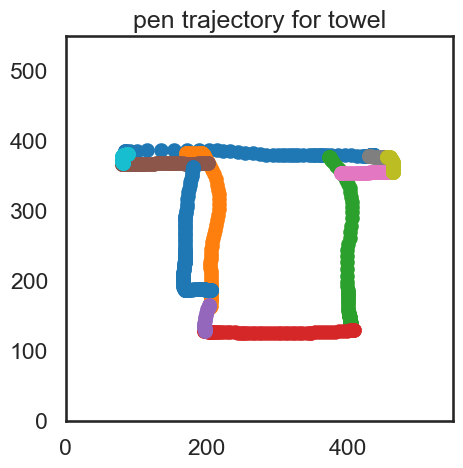

In [16]:
plt.figure(figsize=(5,5))

for stroke in test_strokes:

    xs = [x['x'] for x in stroke if x['action']!='end']
    ys = [x['y'] for x in stroke if x['action']!='end']
    plt.scatter(np.array(xs),550-np.array(ys))
plt.xlim(0,550)
plt.ylim(0,550)
plt.title(f'pen trajectory for {sketch_df.concept[3]}'  )
plt.show()

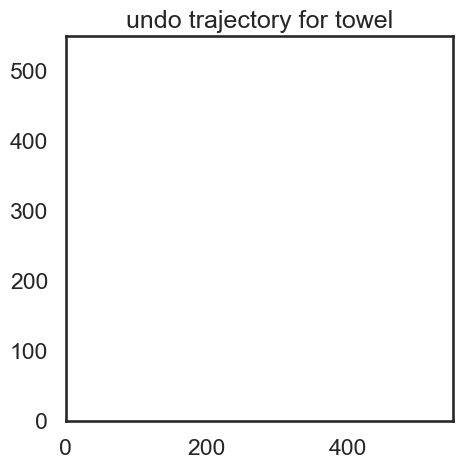

In [17]:
plt.figure(figsize=(5,5))

for stroke in test_undos:

    xs = [x['x'] for x in stroke if x['action']!='end']
    ys = [x['y'] for x in stroke if x['action']!='end']
    plt.scatter(np.array(xs),550-np.array(ys))
plt.xlim(0,550)
plt.ylim(0,550)
plt.title(f'undo trajectory for {sketch_df.concept[3]}' )
plt.show()


### Get a snapshot of both dfs

In [16]:
ratings_meta_df.tail(5)


,Unnamed: 0,_id,rt,response,question_order,concept,trial_type,trial_index,time_elapsed,internal_node_id,pointer_device,iterationName,recruitmentPlatform,workerID,studyID,sessionID,ipInfo
679,679,633d36e484ca0a3028f30ed0,4400.0,{'Q0': 'Yes'},[0],pulley,survey-multi-choice,21,550419,0.0-2.0-1.9,fine,pilot_0,prolific,616c3f3a378cb38f3f7ecac3,633d20c01e6482030c916c66,633d2ef78164579ff7e89066,NaN
680,680,633d36f584ca0a3028f30ed1,16926.0,{'geoconsent': 'yes'},[0],NaN,survey-multi-choice,22,567352,0.0-3.0,fine,pilot_0,prolific,616c3f3a378cb38f3f7ecac3,633d20c01e6482030c916c66,633d2ef78164579ff7e89066,NaN
681,681,633d36f584ca0a3028f30ed2,NaN,NaN,NaN,NaN,call-function,23,567365,0.0-4.0-0.0,fine,pilot_0,prolific,616c3f3a378cb38f3f7ecac3,633d20c01e6482030c916c66,633d2ef78164579ff7e89066,NaN
682,682,633d374984ca0a3028f30ed3,83906.0,"{'Country': 'portugal', 'State': ' vc'}",NaN,NaN,survey-text,24,651337,0.0-4.0-1.0,fine,pilot_0,prolific,616c3f3a378cb38f3f7ecac3,633d20c01e6482030c916c66,633d2ef78164579ff7e89066,"{\n ""ip"": ""89.155.18.14"",\n ""hostname"": ""a89..."
683,683,633d377484ca0a3028f30ed4,43713.0,"{'participantSex': 'Male', 'participantEthnici...","[0, 1, 2, 3, 4]",NaN,survey-multi-choice,25,695056,0.0-5.0,fine,pilot_0,prolific,616c3f3a378cb38f3f7ecac3,633d20c01e6482030c916c66,633d2ef78164579ff7e89066,"{\n ""ip"": ""89.155.18.14"",\n ""hostname"": ""a89..."


In [18]:
sketch_df.tail(5)


,Unnamed: 0,_id,rt,response,concept,prompt,undo_history,png,strokes,trial_type,trial_index,time_elapsed,internal_node_id,pointer_device,iterationName,recruitmentPlatform,workerID,studyID,sessionID
468,468,633d365284ca0a3028f30ecb,28153,button,torch,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 198, 'y': 455, 'color': '#000000', 'ac...",sketchpad,16,404513,0.0-2.0-0.7,fine,pilot_0,prolific,616c3f3a378cb38f3f7ecac3,633d20c01e6482030c916c66,633d2ef78164579ff7e89066
469,469,633d36a284ca0a3028f30ecd,74744,button,earwig,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 129, 'y': 138, 'color': '#000000', 'ac...",sketchpad,18,484433,0.0-2.0-0.8,fine,pilot_0,prolific,616c3f3a378cb38f3f7ecac3,633d20c01e6482030c916c66,633d2ef78164579ff7e89066
470,470,633d36df84ca0a3028f30ecf,57431,button,pulley,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 297, 'y': 128, 'color': '#000000', 'ac...",sketchpad,20,546003,0.0-2.0-0.9,fine,pilot_0,prolific,616c3f3a378cb38f3f7ecac3,633d20c01e6482030c916c66,633d2ef78164579ff7e89066
471,471,634586a384ca0a3028f30ed5,4506,button,dishrag,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 289, 'y': 411, 'color': '#000000', 'ac...",sketchpad,2,7321,0.0-2.0-0.0,fine,pilot_0,prolific,NaN,NaN,NaN
472,472,6357c26c84ca0a3028f30ed6,82817,button,fruitcake,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 151, 'y': 262, 'color': '#000000', 'ac...",sketchpad,2,1573479,0.0-2.0-0.0,fine,pilot_0,prolific,62686c6e90a0f6fe0a6c646a,634c44b07e8d542bf5ff2df6,6357ba339f4902a6af0db128


### Some preliminary plots and stats

In [19]:
### be mindful of the SettingWithCopyWarning

fam_df = ratings_meta_df[(ratings_meta_df.trial_type == 'survey-multi-choice') & (ratings_meta_df.trial_index<22)]
fam_df.response = fam_df.apply(lambda x: eval(x.response), axis=1)
fam_df['response_numeric']  = fam_df.apply(lambda x: 1 if x.response['Q0']=='Yes' else 0,axis=1)

fam_df_grouped = fam_df.groupby('concept').agg({'response_numeric':lambda x: np.mean(x)}).reset_index()


/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_18184/194397141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fam_df.response = fam_df.apply(lambda x: eval(x.response), axis=1)
/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_18184/194397141.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fam_df['response_numeric']  = fam_df.apply(lambda x: 1 if x.response['Q0']=='Yes' else 0,axis=1)


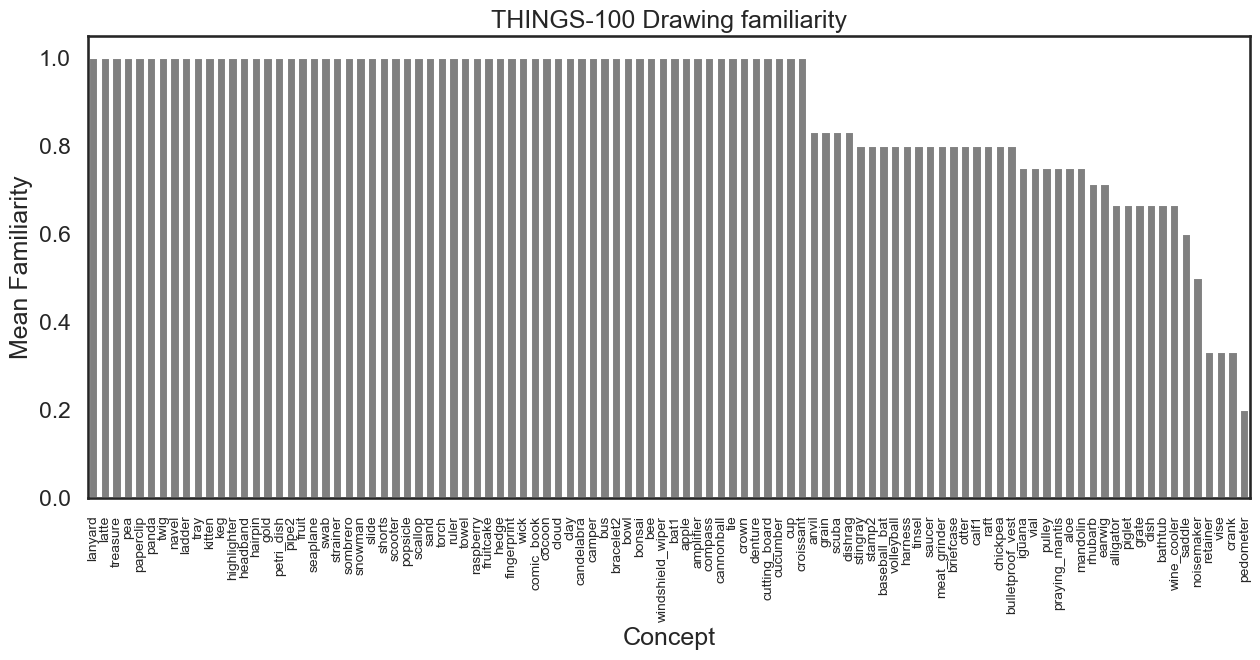

In [20]:
plt.figure(figsize=(15,6))
sns.barplot(fam_df_grouped,x ='concept',y='response_numeric',order=fam_df_grouped.sort_values('response_numeric',ascending=False).concept,color='gray')
plt.xticks(rotation=90,fontsize=10)
plt.ylabel('Mean Familiarity')
plt.xlabel('Concept')
plt.title('THINGS-100 Drawing familiarity')
plt.show()

Text(0.5, 1.0, 'Distribution of number of strokes')

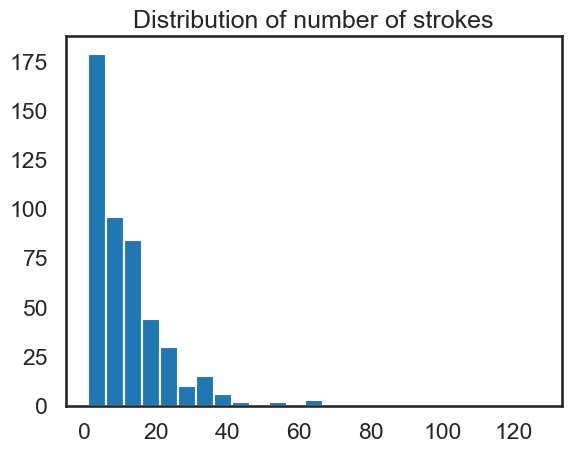

In [45]:
## add number of strokes as a numeric value
sketch_df['num_strokes'] = sketch_df.apply(lambda x: len(x.strokes),axis=1)

plt.hist(sketch_df.num_strokes, bins=25)
plt.title("Distribution of number of strokes")

In [21]:
## add a column of png array
sketch_df['png_array'] = sketch_df.apply(lambda x: string_to_image(x.png), axis=1)


In [44]:
# ## Look at 5 of each sketch!

for concept in sketch_df.concept.unique():
    plot_image_grid(concept,dim=10)

In [58]:
sketch_df.groupby('concept')['num_strokes'].mean()

concept
alligator           11.000000
aloe                 9.750000
amplifier           17.714286
anvil                7.166667
apple                3.666667
                      ...    
vise                 8.166667
volleyball           8.400000
wick                 2.666667
windshield_wiper    17.833333
wine_cooler          8.500000
Name: num_strokes, Length: 100, dtype: float64

In [62]:
sketch_df_grouped = sketch_df.groupby('concept').agg({'num_strokes':lambda x: np.mean(x),'rt':lambda x: np.mean(x)}).reset_index()
sketch_df_grouped

,concept,num_strokes,rt
0,alligator,11.000000,59321.166667
1,aloe,9.750000,40031.750000
2,amplifier,17.714286,76142.857143
3,anvil,7.166667,61465.500000
4,apple,3.666667,21952.333333
...,...,...,...
95,vise,8.166667,39911.833333
96,volleyball,8.400000,59230.000000
97,wick,2.666667,16876.666667
98,windshield_wiper,17.833333,79667.000000


In [64]:
np.corrcoef(sketch_df_grouped.num_strokes ,sketch_df_grouped.rt)


array([[1.       , 0.4179934],
       [0.4179934, 1.       ]])

In [66]:
sketch_df[sketch_df.concept=='pedometer']

,Unnamed: 0,_id,rt,response,concept,prompt,undo_history,png,strokes,trial_type,trial_index,time_elapsed,internal_node_id,pointer_device,iterationName,recruitmentPlatform,workerID,studyID,sessionID,num_strokes
61,61,633d228684ca0a3028f30ae2,41450,button,pedometer,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 140, 'y': 127, 'color': '#000000', 'ac...",sketchpad,4,87505,0.0-2.0-0.1,fine,pilot_0,prolific,615aa900c220b984ac72d063,633d20c01e6482030c916c66,633d221fe910ffa86facb120,6
109,109,633d22d884ca0a3028f30b40,21409,button,pedometer,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 299, 'y': 25, 'color': '#000000', 'act...",sketchpad,12,131866,0.0-2.0-0.5,fine,pilot_0,prolific,5f076c86c025b537201fcd06,633d20c01e6482030c916c66,633d224ffd427678c4138a1b,3
130,130,633d22fb84ca0a3028f30b69,11556,button,pedometer,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 258, 'y': 295, 'color': '#000000', 'ac...",sketchpad,16,225043,0.0-2.0-0.7,fine,pilot_0,prolific,613e5cc0b908c0b63fc98b6e,633d20c01e6482030c916c66,633d22082e9669febc6e1975,2
144,144,633d231384ca0a3028f30b88,47234,button,pedometer,<p style='font-size:25px;font-weight:bold;marg...,[],"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 268, 'y': 87, 'color': '#000000', 'act...",sketchpad,4,158467,0.0-2.0-0.1,fine,pilot_0,prolific,60f5bcf96cd0848f008e3902,633d20c01e6482030c916c66,633d2268e557d3ed74175c35,13
451,451,633d308c84ca0a3028f30ea1,42026,button,pedometer,<p style='font-size:25px;font-weight:bold;marg...,"[[{'x': 415, 'y': 38, 'color': '#000000', 'act...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","[[{'x': 233, 'y': 171, 'color': '#000000', 'ac...",sketchpad,16,389346,0.0-2.0-0.7,fine,pilot_0,prolific,60f06a479c4f3ec0a536d40a,633d20c01e6482030c916c66,633d2ef6956ff2479f0c7792,9


In [73]:
ratings_meta_df.tail(2).iloc[0,:]['response']

"{'participantSex': 'Male', 'participantEthnicity': 'White', 'inputDevice': 'Touch Screen', 'subjectiveSkill': '3', 'imagery': 'somewhat clear'}"

## ☢️ Careful here ☢️

In [ ]:
really_run=False
if really_run==True:
    db.drop_collection('things-100')